# KNN Model Implementation

## Step1: Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split, StratifiedKFold

## Step2: Record Time Cost

In [2]:
import time, os, psutil, atexit                  
process      = psutil.Process(os.getpid())       
_t0          = time.perf_counter()               
_mem0        = process.memory_info().rss         

def _report():
    dt   = time.perf_counter() - _t0            
    mem1 = process.memory_info().rss            
    print(f"\n[STATS] runtime = {dt:,.2f} s")
    print(f"[STATS] memory  = {_mem0/2**20:,.2f} → {mem1/2**20:,.2f} MB "
          f"(Δ {(mem1-_mem0)/2**20:,.2f} MB)")

## Step3: Load in npz File Data

In [3]:
# 1. data loading
data = np.load('image_data.npz')
images_loaded = data['images']
labels_loaded = data['labels']

df = pd.DataFrame({
    'normalized_image_data': list(images_loaded),
    'label': list(labels_loaded)
})

print(f'df.shape: {df.shape}')
    
df_cleaned = df.dropna(subset=['normalized_image_data', 'label'])

print(f'df_cleaned.shape: {df_cleaned.shape}')

df.shape: (1012, 2)
df_cleaned.shape: (1012, 2)


In [4]:
# 2. Extract image arrays and labels
images = np.stack(df_cleaned['normalized_image_data'].values)
labels = df_cleaned['label'].values

## Step4: Glcm Features Extraction

In [5]:
# 3. Handwritten GLCM feature extraction (angle 0°, distance 1), with normalization and cropping to avoid index out-of-bounds.
def extract_glcm_features(images, levels=8):
    features = []
    i_inds, j_inds = np.indices((levels, levels))
    for img in images:
        if img.ndim == 3:
            gray = img.mean(axis=2)
        else:
            gray = img
        # Normalize to [0, 1]
        minv, maxv = gray.min(), gray.max()
        if maxv > minv:
            norm = (gray - minv) / (maxv - minv)
        else:
            norm = np.zeros_like(gray)
        # Quantize to [0, levels - 1]
        quant = np.floor(norm * (levels - 1)).astype(int)
        quant = np.clip(quant, 0, levels - 1)
        # The neighbors of (0°): (i, j) and (i, j + 1)
        g1 = quant[:, :-1].ravel()
        g2 = quant[:, 1:].ravel()
        # Construct the gray-level co-occurrence matrix
        glcm = np.zeros((levels, levels), dtype=float)
        np.add.at(glcm, (g1, g2), 1)
        # symmetrization
        glcm = glcm + glcm.T
        # normalization
        total = glcm.sum()
        P = glcm / total if total > 0 else glcm
        # statistical characterization
        contrast = np.sum(P * (i_inds - j_inds) ** 2)
        dissimilarity = np.sum(P * np.abs(i_inds - j_inds))
        homogeneity = np.sum(P / (1.0 + np.abs(i_inds - j_inds)))
        ASM = np.sum(P ** 2)
        energy = np.sqrt(ASM)
        mu_i = np.sum(i_inds * P)
        mu_j = np.sum(j_inds * P)
        sigma_i = np.sqrt(np.sum((i_inds - mu_i) ** 2 * P))
        sigma_j = np.sqrt(np.sum((j_inds - mu_j) ** 2 * P))
        if sigma_i > 0 and sigma_j > 0:
            correlation = np.sum(((i_inds - mu_i) * (j_inds - mu_j) * P) / (sigma_i * sigma_j))
        else:
            correlation = 0
        features.append([contrast, dissimilarity, homogeneity, ASM, energy, correlation])
    return np.array(features)

# Extract GLCM features
X_glcm = extract_glcm_features(images, levels=8)
df_feat = pd.DataFrame(X_glcm, columns=['contrast','dissimilarity','homogeneity','ASM','energy','correlation'])
df_feat['label'] = labels

## Step5: Split Data

In [6]:
# 4. split
X = df_feat.drop('label', axis=1).values
y = df_feat['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


## Step6: Define KNN Classifier

In [7]:
# mannually compute the var in each features inside dataset
feature_vars = np.var(X_train, axis=0)                # shape = (n_features,)

# 用 1/var 作为权重，再做归一化避免数值过大
# 1/var to be as weight, then normalization
feature_weights = 1 / (feature_vars + 1e-8)
feature_weights = feature_weights / np.max(feature_weights)

# 5. Handwritten KNN classifier
class KNNClassifier:
    def __init__(self, k=5, feature_weights=None):
        self.k = k
        self.feature_weights = feature_weights 
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict_proba(self, X):
        probs = []
        classes = np.unique(self.y_train)
        n_cls = len(classes)
        for x in X:
            if self.feature_weights is None:
                dists = np.linalg.norm(self.X_train - x, axis=1)
            else:
                dists = np.linalg.norm((self.X_train - x) * self.feature_weights, axis=1)

            idx_k = np.argsort(dists)[:self.k]
            counts = np.bincount(self.y_train[idx_k], minlength=n_cls)
            probs.append(counts / self.k)
        return np.array(probs)
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [8]:
# 6. Cross-validation tuning of k (based on F1-score)

# Improved dynamic k selection with robustness to k=1 instability
from statistics import variance

k_list = list(range(3, 16, 2))  # Avoid k=1 by default, consider k=3 to 15
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_results = {}
f1_variances = {}

for k in k_list:
    f1s = []
    feature_vars = np.var(X_train, axis=0)
    feature_weights = 1 / (feature_vars + 1e-8)
    feature_weights = feature_weights / np.max(feature_weights)
    for tr_idx, val_idx in skf.split(X_train, y_train):
        knn = KNNClassifier(k=k, feature_weights=feature_weights)
        knn.fit(X_train[tr_idx], y_train[tr_idx])
        y_val = knn.predict(X_train[val_idx])
        f1s.append(f1_score(y_train[val_idx], y_val))
    f1_results[k] = np.mean(f1s)
    f1_variances[k] = variance(f1s)
    print(f'k={k}, CV F1={f1_results[k]:.4f}, Variance={f1_variances[k]:.4f}')

# Sort by highest mean F1 but prefer lower variance if means are close
sorted_k = sorted(f1_results.items(), key=lambda x: (-x[1], f1_variances[x[0]]))
best_k = sorted_k[0][0]

print(f'Best k based on robust CV F1 = {best_k}\n')

# Visualization
plt.figure()
plt.bar(list(f1_results.keys()), list(f1_results.values()), color='skyblue')
plt.xlabel('k')
plt.ylabel('CV F1-score')
plt.title('KNN Cross-Validation (F1) Results with Variance Consideration')
plt.grid(True)
plt.show()


k=3, CV F1=0.8348, Variance=0.0012
k=5, CV F1=0.8213, Variance=0.0010
k=7, CV F1=0.8220, Variance=0.0026
k=9, CV F1=0.8142, Variance=0.0033
k=11, CV F1=0.8038, Variance=0.0014
k=13, CV F1=0.7979, Variance=0.0016
k=15, CV F1=0.7985, Variance=0.0015
Best k based on robust CV F1 = 3



## Step7: Training Model

Train Accuracy: 0.9307909604519774
Train F1-score: 0.9433526011560693
Test Accuracy: 0.8388
Test Precision: 0.8743
Test Recall: 0.8602
Test F1-score: 0.8672


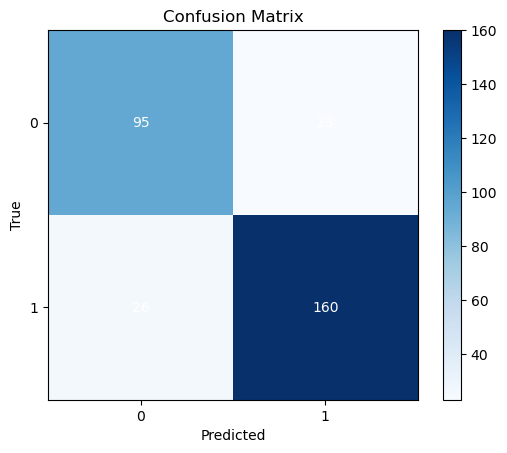

In [9]:
# 7. Test Set Evaluation and Visualization
knn = KNNClassifier(k=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Calculate the metrics of the training set.
train_pred = knn.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train F1-score:", f1_score(y_train, train_pred))

# Output evaluation indicators
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(); plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix'); plt.colorbar()
classes = np.unique(y)
ticks = np.arange(len(classes))
plt.xticks(ticks, classes); plt.yticks(ticks, classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## Step8: Evaluation & Visualization

In [10]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()


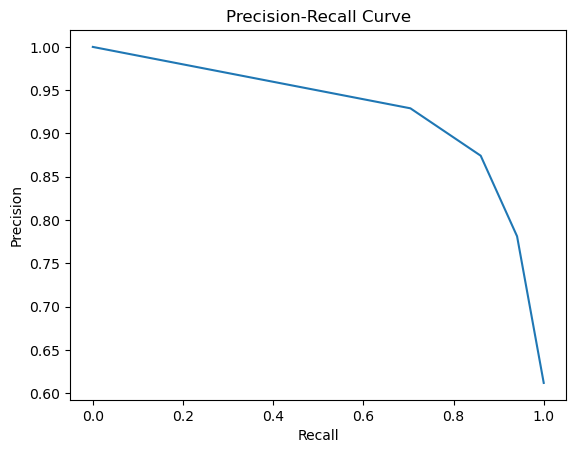

In [11]:
# Precision-Recall
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure(); plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.show()
#

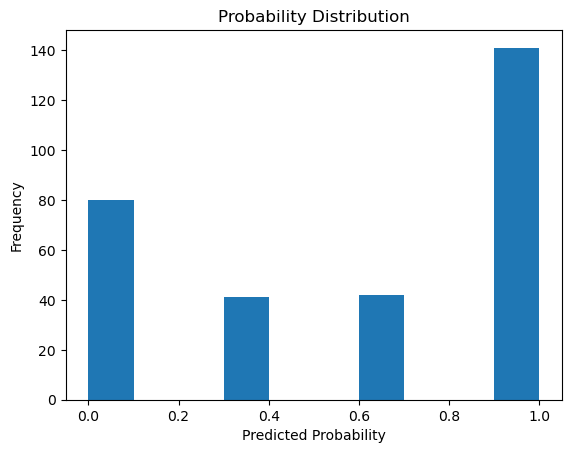

In [12]:
# probability distribution
plt.figure(); plt.hist(y_proba, bins=10)
plt.xlabel('Predicted Probability'); plt.ylabel('Frequency'); plt.title('Probability Distribution'); plt.show()


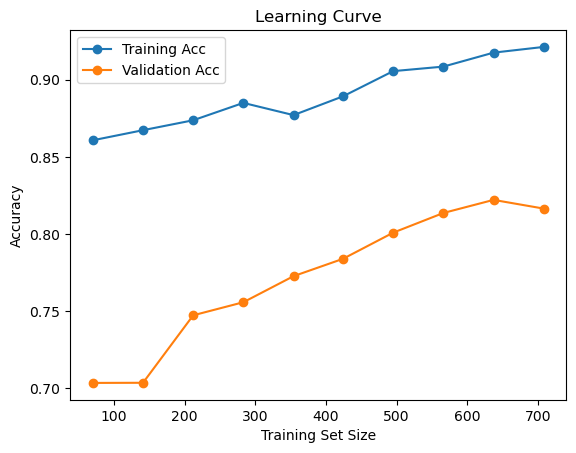

In [13]:
# 8. learning curve
train_sizes=np.linspace(0.1,1.0,10)
train_scores, val_scores = [], []
for frac in train_sizes:
    tr_accs, val_accs = [], []
    for ti,vi in skf.split(X_train,y_train):
        n=int(len(ti)*frac)
        ids_sub=ti[:n]
        knn=KNNClassifier(best_k); knn.fit(X_train[ids_sub],y_train[ids_sub])
        tr_accs.append(accuracy_score(y_train[ids_sub],knn.predict(X_train[ids_sub])))
        val_accs.append(accuracy_score(y_train[vi],knn.predict(X_train[vi])))
    train_scores.append(np.mean(tr_accs))
    val_scores.append(np.mean(val_accs))
# plot
sizes=[int(len(X_train)*s) for s in train_sizes]
plt.figure();
plt.plot(sizes,train_scores,'-o',label='Training Acc')
plt.plot(sizes,val_scores,'-o',label='Validation Acc')
plt.xlabel('Training Set Size');plt.ylabel('Accuracy');plt.title('Learning Curve');plt.legend();plt.show()


## Step9: Record Time Cost & Memory

In [14]:
_report()


[STATS] runtime = 8.30 s
[STATS] memory  = 202.78 → 123.59 MB (Δ -79.19 MB)
